# Tarea 6 P3 ~ Stauber Daniela
## Laplacian Eigenvalues 



This code is used to compute the resonant frequencies and eigenvectors of a cavity. The model is 2-dimensional, that is it corresponds to infinite long structures in the  ẑ direction. 
We need to solve the following eigenfuntion problem: 

$\nabla \cdot \nabla u  = \lambda u \quad\quad\text{ in $\Omega$}$

$u = 0 \text{ on $\partial\Omega$}$

Where $\Omega$ is some 2-dimensional region. 


In order to use finite elements we need to express the problem as a weak one:

$$
\int_{\Omega} \nabla u\,\cdot \nabla v\, {\rm d} x
= \lambda \int_{\Omega} u \cdot v\, {\rm d} x \quad \forall  v \in H^1_0(\Omega),
$$



We shall incorporate a simple, known, case which we shall use to test the implementation, namely:

$\nabla \cdot \nabla u  = \lambda u \quad\quad\text{ in $\Omega$} \quad\quad\quad
\Omega = (0,\pi)\times(0,\pi)$

For this case we know the solutions: 

$u_{n,m}(x,y) = \sin(n x)\sin(m y), \quad \lambda = m^2 + n^2,$ $\quad \lambda = 2, 5, 5, 8, 10, 10, 13, 13, 17, 17, 18, \dots$

We use this case to check that what we are doing is correct. 

In [3]:
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
using gmsh
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack


## Mesh Generation ##

We shall use some meshes which will be contructed in a script to be included below.
It has several grids which can be modified via the parameters or directly modifying the script. 
In particular we have this grids:

**rectangle:**
We shall use a square mesh for testing and then several ones for experimenting: 

**square with a circular hole:**
A square with a circular hole in its interior. It is centered on the square, but then one can experiment moving it from the center. What would happend?

**circle with a circular hole:**
You can also move the hole here.

With the boolean assignments you can choose between cases.

In [4]:
test = false #square 
rectangle = false
square_circle = false
circle_circle = false

#test = true #square 
#rectangle = true
square_circle = true
#circle_circle = true


true

In [5]:
# Create mesh 
include("models/mesh_generator.jl")

make_model (generic function with 1 method)

In [6]:
L = 1
displacement = 0.2
h =0.2

if test 
    grid_type = "test"
    p = (L*π,L*π, h) #for test (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0
elseif rectangle
    grid_type = "rectangle"
    p = (L*π,L*π+displacement, h) #for test / rectangle (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0
elseif square_circle
    grid_type = "square_circle"
    p = (π, π, 0.5*π, 0.5*π + displacement, 0.15*π, h) # for square_circle (Length_x, Length_y, circle_center_x, circle_center_y, radious)
    boundary_tags = ["circle", "ext"]
    dirichlet_tags= ["circle","ext"] 
    dirichlet_values = [0.0,0.0]
elseif circle_circle
    grid_type = "circle_circle"
    p = (0.0, 0.0, 0.5*π, 1.5*π, h) # for circle_circle (cy_center_x, cy_center_y, cy_inner_radious, cy_outer_radious)
    boundary_tags = ["inner","outer"]
    dirichlet_tags=["inner","outer"]
    dirichlet_values = [0.0,0.0]
end

model = make_model(grid_type, p)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.00200295s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0688891s, CPU 0.03125s)
Info    : 816 nodes 1639 elements
Info    : Writing 'models/square_circle.msh'...
Info    : Done writing 'models/square_circle.msh'
Info    : Reading 'models/square_circle.msh'...
Info    : 18 entities
Info    : 815 nodes
Info    : 1630 elements
Info    : Done reading 'models/square_circle.msh'


UnstructuredDiscreteModel()

We now define the triangulation and the measures, in the surface and in the boundary. Then plot them to make sure it is the region we want.

In [7]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

Measure()

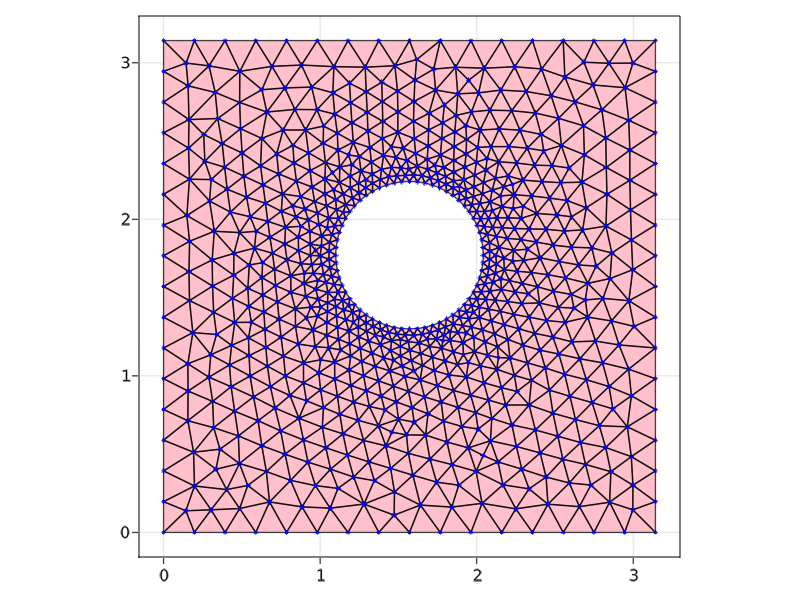

In [8]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

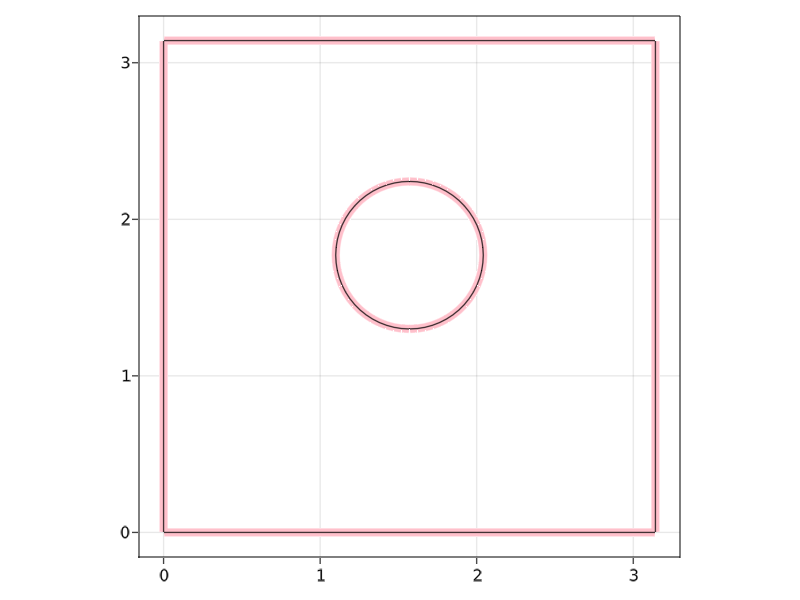

In [9]:
Γ = BoundaryTriangulation(model,tags=boundary_tags)
dΓ = Measure(Γ,degree)
fig, ax = plot(Γ, linewidth=8)
ax.aspect = AxisAspect(1)
wireframe!(Γ, color=:black, linewidth=1)
fig

In [10]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)


TrialFESpace()

In [11]:
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
m(u,v) = ∫(u*v)dΩ


m (generic function with 1 method)

In [12]:
include("eigen.jl")


solve (generic function with 1 method)

In [13]:
nev = 10 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev = nev)
ξ, uₕs = solve(prob);


We now can plot the eigen-functions. To do that we choose them using the index in which they are saved.

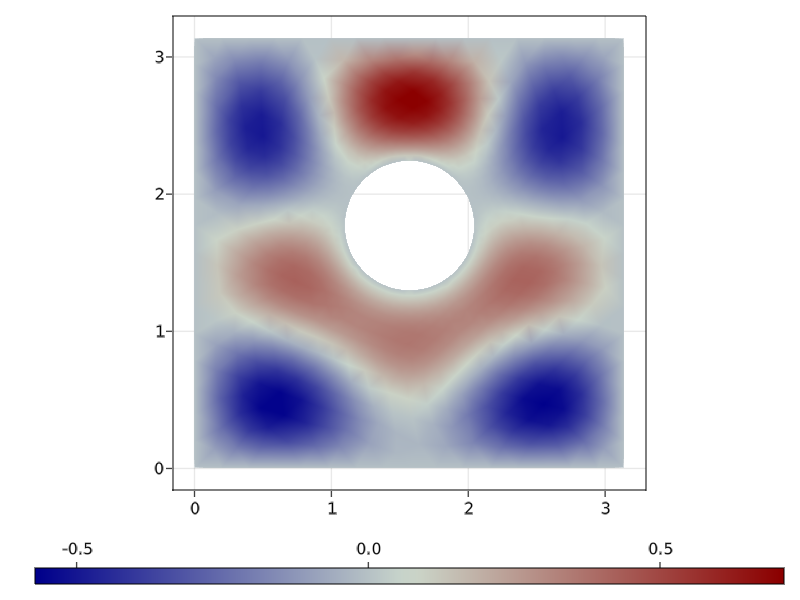

In [14]:
uₕ = uₕs[8]
fig, ax, plt = plot(Ω, real(uₕ))
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

We can plot the eigenvalues:

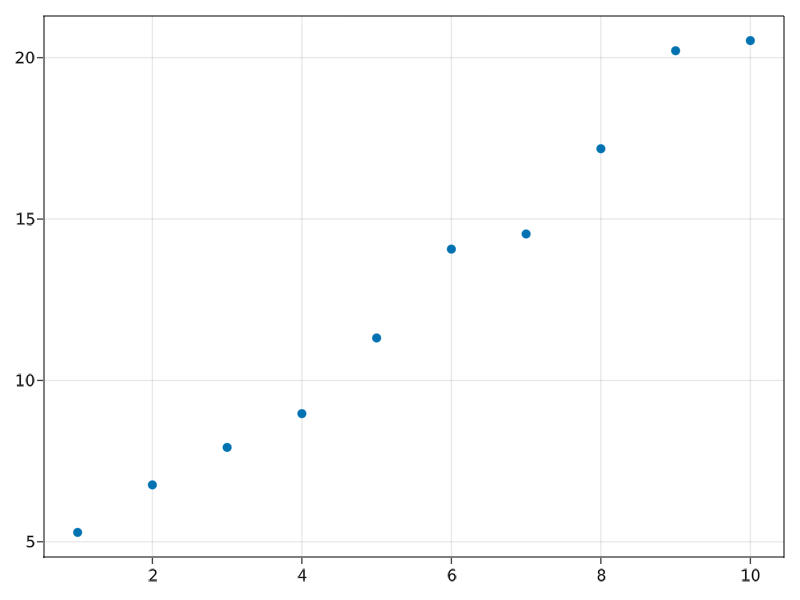

In [15]:
scatter(real(ξ))

In [16]:
ξ

10-element Vector{ComplexF64}:
  5.290346158164115 - 2.0577088260833708e-16im
    6.7632757588659 - 1.9459494888600526e-16im
  7.924010859801215 + 8.374574541203548e-17im
   8.97080093967977 + 5.181533394031021e-16im
 11.315536764544541 + 1.0241839740770914e-15im
 14.068429522315471 + 4.596452271834401e-16im
 14.538276285484786 - 4.417621446667459e-16im
  17.17972741123229 - 1.2172926420908305e-15im
 20.216313043468656 - 5.644381089054478e-16im
  20.53011129852636 + 2.5468828847431675e-16im

GLFWError (PLATFORM_ERROR): WGL: Failed to make context current: La operación se completó correctamente. 
Stacktrace:
 [1] _ErrorCallbackWrapper(code::Int32, description::Cstring)
   @ GLFW C:\Users\LENOVO\.julia\packages\GLFW\BWxfF\src\callback.jl:43
 [2] MakeContextCurrent
   @ C:\Users\LENOVO\.julia\packages\GLFW\BWxfF\src\glfw3.jl:694 [inlined]
 [3] make_context_current
   @ C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\drawing_primitives.jl:46 [inlined]
 [4] fps_renderloop(screen::GLMakie.Screen, framerate::Float64)
   @ GLMakie C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\rendering.jl:26
 [5] renderloop(screen::GLMakie.Screen; framerate::Float64)
   @ GLMakie C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\rendering.jl:48
 [6] renderloop(screen::GLMakie.Screen)
   @ GLMakie C:\Users\LENOVO\.julia\packages\GLMakie\lcQNS\src\rendering.jl:41
 [7] (::GLMakie.var"#50#52"{GLMakie.Screen})()
   @ GLMakie .\task.jl:411


### Estudiemos la convergencia

In [4]:
N= [1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [5]:
H=zeros(3)
Q=zeros(ComplexF64, 3)

3-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [6]:
degree = 3
#degree=2

3

In [7]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)

(Lagrangian(), (Float64, 2), Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [8]:
nev = 10 # number of eigenvalues asked to evaluate.

10

### h=0.5

In [9]:
    L = 1
    displacement = 0.0
    H[1] = 1/(2^N[1])
    
    grid_type = "rectangle"
    p = (L*π,L*π+displacement, H[1]) #for test / rectangle (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0

    model = make_model(grid_type, p)

    Ω = Triangulation(model)
    dΩ = Measure(Ω,degree)
    

    V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
    U = TrialFESpace(V,dirichlet_values)
    
    a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
    m(u,v) = ∫(u*v)dΩ
    

    prob = EigenProblem(a, m, U, V; nev = nev)
    ξ, uₕs = solve(prob);
    
    uₕ=uₕs[1]
    u11= sum(∫(uₕ*uₕ)*dΩ)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00102305s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00198102s, CPU 0s)
Info    : 75 nodes 152 elements
Info    : Writing 'models/rectangle.msh'...
Info    : Done writing 'models/rectangle.msh'
Info    : Reading 'models/rectangle.msh'...
Info    : 9 entities
Info    : 75 nodes
Info    : 148 elements
Info    : Done reading 'models/rectangle.msh'


-0.7150187285724611 - 0.6991052980707725im

### h=0.25

In [10]:
     L = 1
    displacement = 0.0
    H[2] = 1/(2^N[2])
    
    grid_type = "rectangle"
    p = (L*π,L*π+displacement, H[2]) #for test / rectangle (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0

    model = make_model(grid_type, p)

    Ω = Triangulation(model)
    dΩ = Measure(Ω,degree)
    

    V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
    U = TrialFESpace(V,dirichlet_values)
    
    a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
    m(u,v) = ∫(u*v)dΩ
    

    prob = EigenProblem(a, m, U, V; nev = nev)
    ξ, uₕs2 = solve(prob);
    
    uₕ2=uₕs2[1]
    u21= sum(∫(uₕ2*uₕ2)*dΩ)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00102282s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00801587s, CPU 0s)
Info    : 231 nodes 464 elements
Info    : Writing 'models/rectangle.msh'...
Info    : Done writing 'models/rectangle.msh'
Info    : Reading 'models/rectangle.msh'...
Info    : 9 entities
Info    : 231 nodes
Info    : 460 elements
Info    : Done reading 'models/rectangle.msh'


0.9979796497662203 - 0.0635343895263957im

### h=0.125

In [11]:
     L = 1
    displacement = 0.0
    H[3] = 1/(2^N[3])
    
    grid_type = "rectangle"
    p = (L*π,L*π+displacement, H[3]) #for test / rectangle (Length_x, Length_y, h) 
    boundary_tags = ["ext"]
    dirichlet_tags= ["ext"]
    dirichlet_values = 0.0 # 0.0+im*0.0

    model = make_model(grid_type, p)

    Ω = Triangulation(model)
    dΩ = Measure(Ω,degree)
    

    V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
    U = TrialFESpace(V,dirichlet_values)
    
    a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
    m(u,v) = ∫(u*v)dΩ
    

    prob = EigenProblem(a, m, U, V; nev = nev)
    ξ, uₕs3 = solve(prob);
    
    uₕ3=uₕs3[1]
    u31= sum(∫(uₕ3*uₕ3)*dΩ)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0280583s, CPU 0.03125s)
Info    : 842 nodes 1686 elements
Info    : Writing 'models/rectangle.msh'...
Info    : Done writing 'models/rectangle.msh'
Info    : Reading 'models/rectangle.msh'...
Info    : 9 entities
Info    : 842 nodes
Info    : 1682 elements
Info    : Done reading 'models/rectangle.msh'


-0.6999124865267773 + 0.7142286127031783im

In [12]:
el2_12= uₕs[1]/sqrt(u11) - uₕs2[1]/sqrt(u21) 

LoadError: 

You are trying to operate CellField objects defined on incompatible triangulations.

Make sure that all CellField objects are defined on the background triangulation
or that the number of different sub-triangulations is equal to one.

For instace:

- 3 cell fields 2, two them on the same Neumann boundary and the other on the background mesh is OK.

- 2 cell fields defined on 2 different Neumann boundaries is NOT OK.


In [ ]:
el2_23= uₕs2[1]/sqrt(u21) - uₕs3[1]/sqrt(u31) 